In [1]:
import numpy as np
import pandas as pd
import datatable as dt
import time
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn import pipeline
from sklearn.pipeline import *
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import *
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# Encoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder

# Home made
from cmougan import *

Load Data

In [2]:
accidents = pd.read_csv('Dataset & booklet/accidents.csv')
vehicles = pd.read_csv('Dataset & booklet/vehicles.csv')
test = pd.read_csv('Dataset & booklet/test.csv')

In [3]:
train=pd.read_csv('Dataset & booklet/train_v1.csv')

/Users/cmougan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (25,79,80,81) have mixed types. Specify dtype option on import or set low_memory=False.



# Validation

The goal of time series forecasting is to make accurate predictions about the future.

The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.

In [4]:
target = train.target
train = train.drop(columns=['target'])
tscv = sklearn.model_selection.TimeSeriesSplit(n_splits=6)
for train_index, test_index in tscv.split(train):
        print("TRAIN:", len(train_index), "TEST:", len(test_index),"SUM:",len(train_index)+len(test_index))
        X_tr, X_te = train.iloc[train_index], train.iloc[test_index]
        y_tr, y_te = target.iloc[train_index], target.iloc[test_index]


TRAIN: 19657 TEST: 19657 SUM: 39314
TRAIN: 39314 TEST: 19657 SUM: 58971
TRAIN: 58971 TEST: 19657 SUM: 78628
TRAIN: 78628 TEST: 19657 SUM: 98285
TRAIN: 98285 TEST: 19657 SUM: 117942
TRAIN: 117942 TEST: 19657 SUM: 137599


Categorical columns that we consider that are worth to encode

In [5]:
cols_enc =['1st_road_class', '1st_road_number', 'road_type','speed_limit', 
           'junction_detail', 'junction_control', '2nd_road_class','pedestrian_crossing-human_control', 
           'pedestrian_crossing-physical_facilities', 'light_conditions', 'weather_conditions', 
           'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area',
          'police_force', 'local_authority_district', 'local_authority_highway',
          'mode_Vehicle_Type', 'mode_Towing_and_Articulation', 'mode_Vehicle_Manoeuvre', 
           'mode_Vehicle_Location.Restricted_Lane', 'mode_Junction_Location', 'mode_Skidding_and_Overturning',
           'mode_Hit_Object_in_Carriageway', 'mode_Vehicle_Leaving_Carriageway', 'mode_Hit_Object_off_Carriageway',
           'mode_X1st_Point_of_Impact', 'mode_Was_Vehicle_Left_Hand_Drive.', 'mode_Journey_Purpose_of_Driver', 
           'mode_Sex_of_Driver', 'mode_Propulsion_Code','vehicles','impact_points','manoeuvres']

## Lasso 

First we train a simple model to interprete the results and have a baseline. We choose Lasso as it automatically selects relevant features.


For Caterogrical Features we use target encoding to transform to numeric.

In [6]:
target = Encodings(encoding_type="TargetEncoder",columns=cols_enc)
woe = Encodings(encoding_type="WOEEncoder",columns=cols_enc)
cbe = Encodings(encoding_type="CatBoostEncoder",columns=cols_enc)
clf = sklearn.linear_model.LogisticRegression()
scaler = StandardScaler()


encodings = Pipeline([('target',target),
                      #('cbe',cbe)
                     ])

pipe_clf = Pipeline([
    ('encodings',encodings),
    ('selector', TypeSelector(np.number)), # Selects Numerical Columns only
    ('scaler',scaler),
                     
                     #('pca',pca),
                     #('featgen',featgen),
                    ('clf',clf)
                   ])

pipeline_grid = {
   
    "clf__penalty":['l1','l2'],
    "clf__C":[0.556,0.8],
    #"clf__class_weight":[None]

        }

We search through GridSearch to find optimal parameter via Cross Validation

In [7]:
# Execution Hyperparameters
n_jobs=-1
cv = 3
n_max= 25_000
pipe_cv = GridSearchCV(pipe_clf, param_grid=pipeline_grid, n_jobs = n_jobs, cv=cv,scoring='f1')

In [8]:
%%time
pipe_cv, pipe_best_estimator_lasso  = fit_cv_subsample(pipe_cv, X_tr, y_tr, n_max = n_max);
pipe_best_estimator_lasso.fit(X_tr,y_tr);
score_train = f1_score(y_tr,pipe_best_estimator_lasso.predict(X_tr))
scorte_test = f1_score(y_te,pipe_best_estimator_lasso.predict(X_te))

/Users/cmougan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/cmougan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



CPU times: user 25.2 s, sys: 1.43 s, total: 26.6 s
Wall time: 28.5 s


78 features, reduction of 0.00%


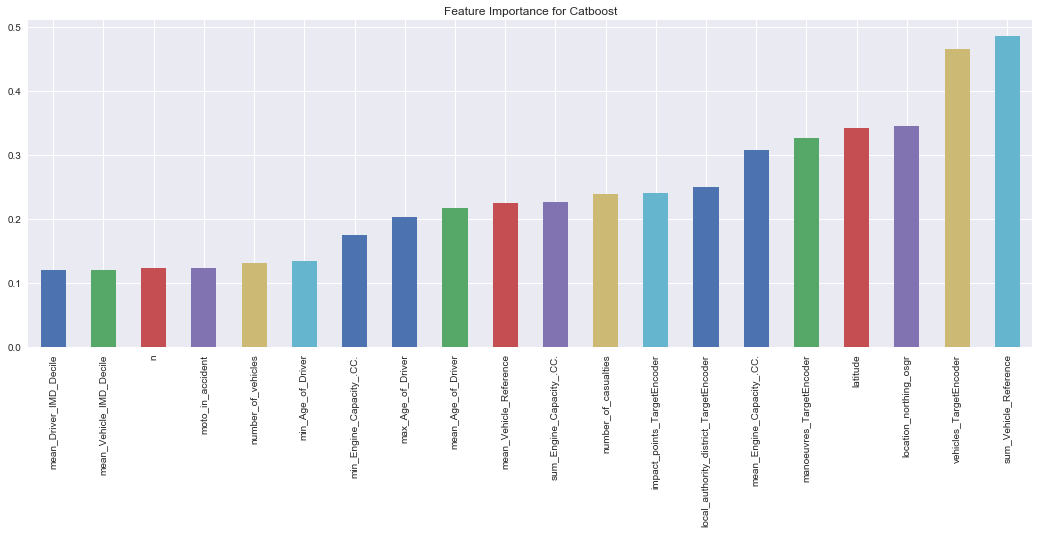

In [9]:
plot_feature_importance(pipe_best_estimator_lasso[:-2].transform(X_tr).columns,np.array(pipe_best_estimator_lasso.named_steps['clf'].coef_.squeeze()),20)

Feature Importance for Lasso Model. This is a good way to provide bussiness insights since it has a good XAI

**Optimal cut off to translate to F1 Score**

In train set we look for the optimal cutoff by searching the Grid

In [10]:
%%time
max_f1 = 0
for thres in np.linspace(0.1,0.4,5):
    pred = pipe_best_estimator_lasso.predict_proba(X_tr)[:,1]>thres
    f1 = f1_score(y_tr,pred)
    #print(f1)    
    if f1 > max_f1:
        max_f1=f1
        cutoff = thres

CPU times: user 12.4 s, sys: 1.68 s, total: 14.1 s
Wall time: 10.3 s


In [11]:
score_train = f1_score(y_tr,pipe_best_estimator_lasso.predict_proba(X_tr)[:,1]>cutoff)
scorte_test = f1_score(y_te,pipe_best_estimator_lasso.predict_proba(X_te)[:,1]>cutoff)

print('The score of the gradient boosting algorithm in train is',
      np.round((score_train),decimals=4))

print('The score of the gradient boosting algorithm in test is',
      np.round((scorte_test),decimals=4))

The score of the gradient boosting algorithm in train is 0.4134
The score of the gradient boosting algorithm in test is 0.4153


There is no overfitting and performance is reasonably high

### Catboost
https://catboost.ai

We try a more complex model to model the dataset and obtain better predictions

In [16]:
target = Encodings(encoding_type="TargetEncoder",columns=cols_enc)
woe = Encodings(encoding_type="WOEEncoder",columns=cols_enc)
cbe = Encodings(encoding_type="CatBoostEncoder",columns=cols_enc)
cb = CatBoostClassifier(random_seed=1,iterations=300,)

encodings = Pipeline([
                     ('te',target),
                         ])

pipe_cb = Pipeline([ ('encodings',encodings),             # Encoding of Categorical Variables
                 ('selector', TypeSelector(np.number)), # Selects Numerical Columns only
                    ('cb',cb)
                   ])

pipeline_grid = {
    

        }

In [17]:
# Execution Hyperparameters
n_jobs=-1
cv = 3
n_max= int(X_tr.shape[0]/10)
pipe_cv = GridSearchCV(pipe_cb, param_grid=pipeline_grid, n_jobs = n_jobs, cv=cv,scoring='roc_auc')


In [18]:
%%time
pipe_cv, pipe_best_estimator  = fit_cv_subsample(pipe_cv, X_tr, y_tr, n_max = n_max);

Learning rate set to 0.098467
0:	learn: 0.6164153	total: 127ms	remaining: 37.9s
1:	learn: 0.5516414	total: 143ms	remaining: 21.4s
2:	learn: 0.5049085	total: 162ms	remaining: 16s
3:	learn: 0.4662615	total: 186ms	remaining: 13.8s
4:	learn: 0.4382347	total: 203ms	remaining: 12s
5:	learn: 0.4157514	total: 217ms	remaining: 10.6s
6:	learn: 0.3953851	total: 229ms	remaining: 9.6s
7:	learn: 0.3817468	total: 242ms	remaining: 8.82s
8:	learn: 0.3713650	total: 254ms	remaining: 8.2s
9:	learn: 0.3622365	total: 266ms	remaining: 7.7s
10:	learn: 0.3531685	total: 278ms	remaining: 7.29s
11:	learn: 0.3470185	total: 293ms	remaining: 7.04s
12:	learn: 0.3422359	total: 312ms	remaining: 6.89s
13:	learn: 0.3376658	total: 330ms	remaining: 6.75s
14:	learn: 0.3350393	total: 344ms	remaining: 6.53s
15:	learn: 0.3320160	total: 356ms	remaining: 6.32s
16:	learn: 0.3298625	total: 368ms	remaining: 6.12s
17:	learn: 0.3282748	total: 380ms	remaining: 5.95s
18:	learn: 0.3262331	total: 392ms	remaining: 5.79s
19:	learn: 0.32441

167:	learn: 0.2549357	total: 2.69s	remaining: 2.11s
168:	learn: 0.2544530	total: 2.7s	remaining: 2.09s
169:	learn: 0.2542532	total: 2.71s	remaining: 2.07s
170:	learn: 0.2539013	total: 2.72s	remaining: 2.05s
171:	learn: 0.2534497	total: 2.73s	remaining: 2.04s
172:	learn: 0.2530964	total: 2.75s	remaining: 2.02s
173:	learn: 0.2529107	total: 2.76s	remaining: 2s
174:	learn: 0.2527487	total: 2.77s	remaining: 1.98s
175:	learn: 0.2526039	total: 2.78s	remaining: 1.96s
176:	learn: 0.2524400	total: 2.79s	remaining: 1.94s
177:	learn: 0.2520672	total: 2.8s	remaining: 1.92s
178:	learn: 0.2514982	total: 2.81s	remaining: 1.9s
179:	learn: 0.2510203	total: 2.83s	remaining: 1.88s
180:	learn: 0.2508070	total: 2.84s	remaining: 1.86s
181:	learn: 0.2504724	total: 2.85s	remaining: 1.85s
182:	learn: 0.2499970	total: 2.86s	remaining: 1.83s
183:	learn: 0.2498135	total: 2.87s	remaining: 1.81s
184:	learn: 0.2494798	total: 2.89s	remaining: 1.8s
185:	learn: 0.2493047	total: 2.91s	remaining: 1.78s
186:	learn: 0.24898

In [19]:
pipe_best_estimator.fit(X_tr,y_tr);

Learning rate set to 0.188926
0:	learn: 0.5812220	total: 71.1ms	remaining: 21.3s
1:	learn: 0.5149349	total: 147ms	remaining: 21.9s
2:	learn: 0.4756237	total: 201ms	remaining: 19.9s
3:	learn: 0.4474019	total: 249ms	remaining: 18.4s
4:	learn: 0.4334356	total: 292ms	remaining: 17.2s
5:	learn: 0.4221246	total: 340ms	remaining: 16.7s
6:	learn: 0.4157572	total: 387ms	remaining: 16.2s
7:	learn: 0.4105265	total: 434ms	remaining: 15.8s
8:	learn: 0.4058900	total: 489ms	remaining: 15.8s
9:	learn: 0.4028073	total: 550ms	remaining: 16s
10:	learn: 0.4008877	total: 601ms	remaining: 15.8s
11:	learn: 0.3986267	total: 656ms	remaining: 15.7s
12:	learn: 0.3969249	total: 705ms	remaining: 15.6s
13:	learn: 0.3959549	total: 751ms	remaining: 15.3s
14:	learn: 0.3951078	total: 799ms	remaining: 15.2s
15:	learn: 0.3942375	total: 844ms	remaining: 15s
16:	learn: 0.3934343	total: 892ms	remaining: 14.8s
17:	learn: 0.3928672	total: 940ms	remaining: 14.7s
18:	learn: 0.3923818	total: 987ms	remaining: 14.6s
19:	learn: 0.3

162:	learn: 0.3691213	total: 9.61s	remaining: 8.07s
163:	learn: 0.3690030	total: 9.65s	remaining: 8s
164:	learn: 0.3689160	total: 9.69s	remaining: 7.93s
165:	learn: 0.3688122	total: 9.74s	remaining: 7.86s
166:	learn: 0.3687247	total: 9.78s	remaining: 7.79s
167:	learn: 0.3686370	total: 9.82s	remaining: 7.72s
168:	learn: 0.3685266	total: 9.87s	remaining: 7.65s
169:	learn: 0.3684179	total: 9.91s	remaining: 7.58s
170:	learn: 0.3683429	total: 9.95s	remaining: 7.51s
171:	learn: 0.3682362	total: 10s	remaining: 7.44s
172:	learn: 0.3681314	total: 10s	remaining: 7.37s
173:	learn: 0.3680431	total: 10.1s	remaining: 7.3s
174:	learn: 0.3679134	total: 10.1s	remaining: 7.23s
175:	learn: 0.3677369	total: 10.2s	remaining: 7.17s
176:	learn: 0.3675841	total: 10.2s	remaining: 7.1s
177:	learn: 0.3675104	total: 10.3s	remaining: 7.03s
178:	learn: 0.3674118	total: 10.3s	remaining: 6.97s
179:	learn: 0.3672795	total: 10.4s	remaining: 6.9s
180:	learn: 0.3671834	total: 10.4s	remaining: 6.83s
181:	learn: 0.3671028	

In [20]:
print('The AUC of the gradient boosting algorithm in train is',
      np.round(auc_score(y_tr,pipe_best_estimator.predict_proba(X_tr)),decimals=2))

print('The AUC of the gradient boosting algorithm in test is',
      np.round(auc_score(y_te,pipe_best_estimator.predict_proba(X_te)),decimals=2))

The AUC of the gradient boosting algorithm in train is 0.81
The AUC of the gradient boosting algorithm in test is 0.74


In [21]:
score_train = f1_score(y_tr,pipe_best_estimator.predict(X_tr))
scorte_test = f1_score(y_te,pipe_best_estimator.predict(X_te))

print('The f1-score of the gradient boosting algorithm in train is',
      np.round((score_train),decimals=3))

print('The f1-score of the gradient boosting algorithm in test is',
      np.round((scorte_test),decimals=3))

The f1-score of the gradient boosting algorithm in train is 0.29
The f1-score of the gradient boosting algorithm in test is 0.266


78 features, reduction of 0.00%


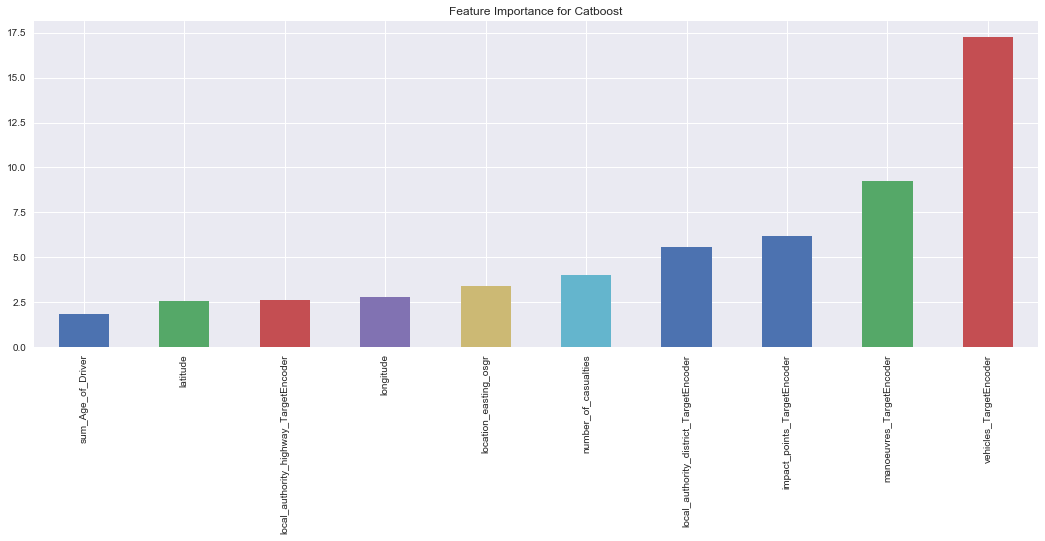

In [25]:
plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,
                        pipe_best_estimator.named_steps['cb'].get_feature_importance(),10)

The best features are composition of vehicles, manouvers and collision points.

In [23]:
%%time
max_f1 = 0
for thres in np.linspace(0.1,0.4,10):
    pred = pipe_best_estimator.predict_proba(X_tr)[:,1]>thres
    f1 = f1_score(y_tr,pred)
    #print(f1)    
    if f1 > max_f1:
        max_f1=f1
        cutoff = thres

CPU times: user 34.5 s, sys: 3.27 s, total: 37.8 s
Wall time: 31.1 s


In [24]:
score_train = f1_score(y_tr,pipe_best_estimator.predict_proba(X_tr)[:,1]>cutoff)
scorte_test = f1_score(y_te,pipe_best_estimator.predict_proba(X_te)[:,1]>cutoff)

print('The score of the gradient boosting algorithm in train is',
      np.round((score_train),decimals=4))

print('The score of the gradient boosting algorithm in test is',
      np.round((scorte_test),decimals=4))

The score of the gradient boosting algorithm in train is 0.4969
The score of the gradient boosting algorithm in test is 0.4414


We improve the results significally

# XGB 

Thought it doesnt increase performance we used this famous model to validate high accuracy results

target = Encodings(encoding_type="TargetEncoder",columns=cols_enc)
woe = Encodings(encoding_type="WOEEncoder",columns=cols_enc)
cbe = Encodings(encoding_type="CatBoostEncoder",columns=cols_enc)
xgb = XGBClassifier()

encodings = Pipeline([
                     ('te',target),
                         ])

pipe_cb = Pipeline([ ('encodings',encodings),             # Encoding of Categorical Variables
                 ('selector', TypeSelector(np.number)), # Selects Numerical Columns only
                    ('xgb',xgb)
                   ])

pipeline_grid = {
    
        'xgb__min_child_weight': [1, 10],
        'xgb__gamma': [0.5, 5],
        'xgb__subsample': [0.6,  1.0],
        'xgb__colsample_bytree': [0.6, 1.0],
        'xgb__max_depth': [3,  5]
        }

In [ ]:
# Execution Hyperparameters
n_jobs=-1
cv = 3
n_max= int(X_tr.shape[0]/10)
pipe_cv = GridSearchCV(pipe_cb, param_grid=pipeline_grid, n_jobs = n_jobs, cv=cv,scoring='roc_auc')


In [ ]:
%%time
pipe_cv, pipe_best_estimator  = fit_cv_subsample(pipe_cv, X_tr, y_tr, n_max = n_max);
pipe_best_estimator.fit(X_tr,y_tr);

In [ ]:
print('The AUC of the gradient boosting algorithm in train is',
      np.round(auc_score(y_tr,pipe_best_estimator.predict_proba(X_tr)),decimals=2))

print('The AUC of the gradient boosting algorithm in test is',
      np.round(auc_score(y_te,pipe_best_estimator.predict_proba(X_te)),decimals=2))

In [ ]:
score_train = f1_score(y_tr,pipe_best_estimator.predict(X_tr))
scorte_test = f1_score(y_te,pipe_best_estimator.predict(X_te))

print('The f1-score of the gradient boosting algorithm in train is',
      np.round((score_train),decimals=3))

print('The f1-score of the gradient boosting algorithm in test is',
      np.round((scorte_test),decimals=3))

In [ ]:
plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,
                        pipe_best_estimator.named_steps['xgb'].feature_importances_,20)

In [ ]:
%%time
max_f1 = 0
for thres in np.linspace(0.1,0.4,10):
    pred = pipe_best_estimator.predict_proba(X_tr)[:,1]>thres
    f1 = f1_score(y_tr,pred)
    #print(f1)    
    if f1 > max_f1:
        max_f1=f1
        cutoff = thres

In [ ]:
score_train = f1_score(y_tr,pipe_best_estimator.predict_proba(X_tr)[:,1]>cutoff)
scorte_test = f1_score(y_te,pipe_best_estimator.predict_proba(X_te)[:,1]>cutoff)

print('The score of the gradient boosting algorithm in train is',
      np.round((score_train),decimals=4))

print('The score of the gradient boosting algorithm in test is',
      np.round((scorte_test),decimals=4))

**Model Comparison**

(https://github.com/david26694/model-comparison-training/blob/master/xaringan_presentation/ML%20Models%20Comparison.pdf)

Given two models trained in the same dataset, we want to asses which one is better according to a given metric.

Requirements:
- We should not use test set to assess
- We should embrace uncertainty

Solutions:
- Metrics in cross validation folds (trust your local CV)
- Always use the same folds
    

We won't be doing model comparison in this assignment. It is easy to see that gradient boosting has a better performance over Lasso, but Lasso gives us an explainable model that is easy to understand and deliver bussiness insights. For a better performance several strategies could be used as avoiding the shortcuts done in the introduction. Also more models could be used to address the problem.

One thing that we can notice is that the most important variables are not the same for each model. That means that the ones in gradient boosting have a nonlinear behaviour. 